In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file
from skimage.segmentation import find_boundaries

from nurisc import edt_prob, star_dist, fill_label_holes
from nurisc import random_label_cmap, draw_polygons, ray_angles

from nurisc.nms import _non_maximum_suppression_old as non_maximum_suppression
from nurisc.geometry import _dist_to_coord_old as dist_to_coord
from nurisc.geometry import _polygons_to_label_old as polygons_to_label

np.random.seed(42)
lbl_cmap = random_label_cmap()

C:\Users\es255022\AppData\Local\Temp\ipykernel_22820\112934767.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [2]:
#PANNUKE
X=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/images/fold3/images.npy')
Y1=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/masks/fold3/masks.npy')
Y=Y1.astype(int)
Y = [y[...,0] for y in Y]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/nurisc/nurisc/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading...

KeyboardInterrupt: 

In [20]:
# X = sorted(glob('data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_1/Fold 1/images/fold1/images.npy')
Y1=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_1/Fold 1/masks/fold1/masks.npy')
Y=Y1.astype('int32')
Y = [y[...,0] for y in Y]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Load only a small subset.

In [3]:
X, Y = X[:10], Y[:10]

In [21]:
X = list(map(imread,X))
Y = list(map(imread,Y))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from nurisc import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from nurisc.matching import matching, matching_dataset
from nurisc.models import Config2D, nurisc2D, nuriscData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

222649726.py (5): Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [8]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████| 10/10 [00:00<00:00, 631.68it/s]


In [9]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


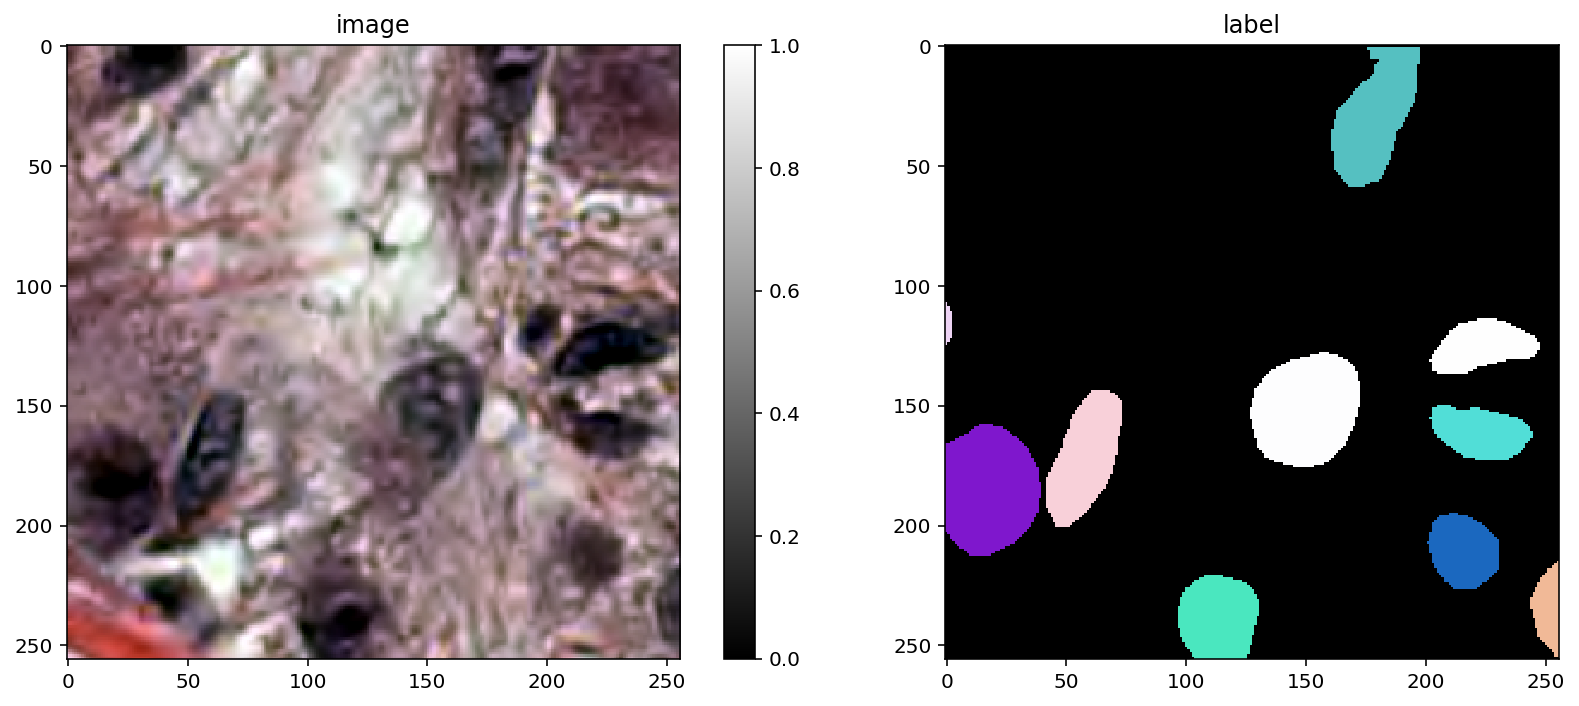

In [10]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [11]:
i = min(100, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
# img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


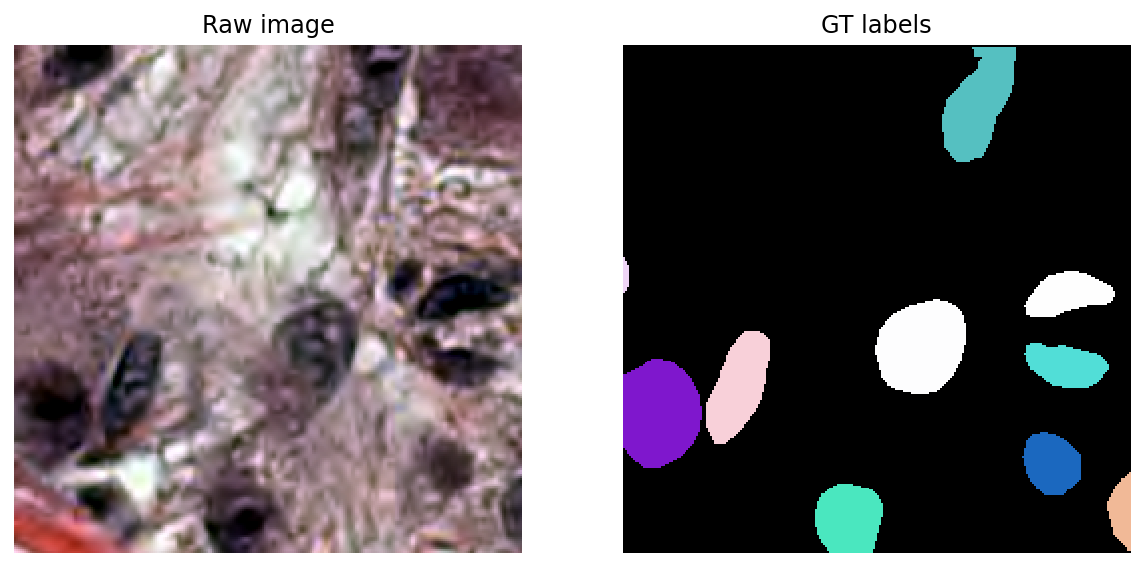

In [12]:
plt.figure(figsize=(10,10))
# plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(121); plt.imshow(img);   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

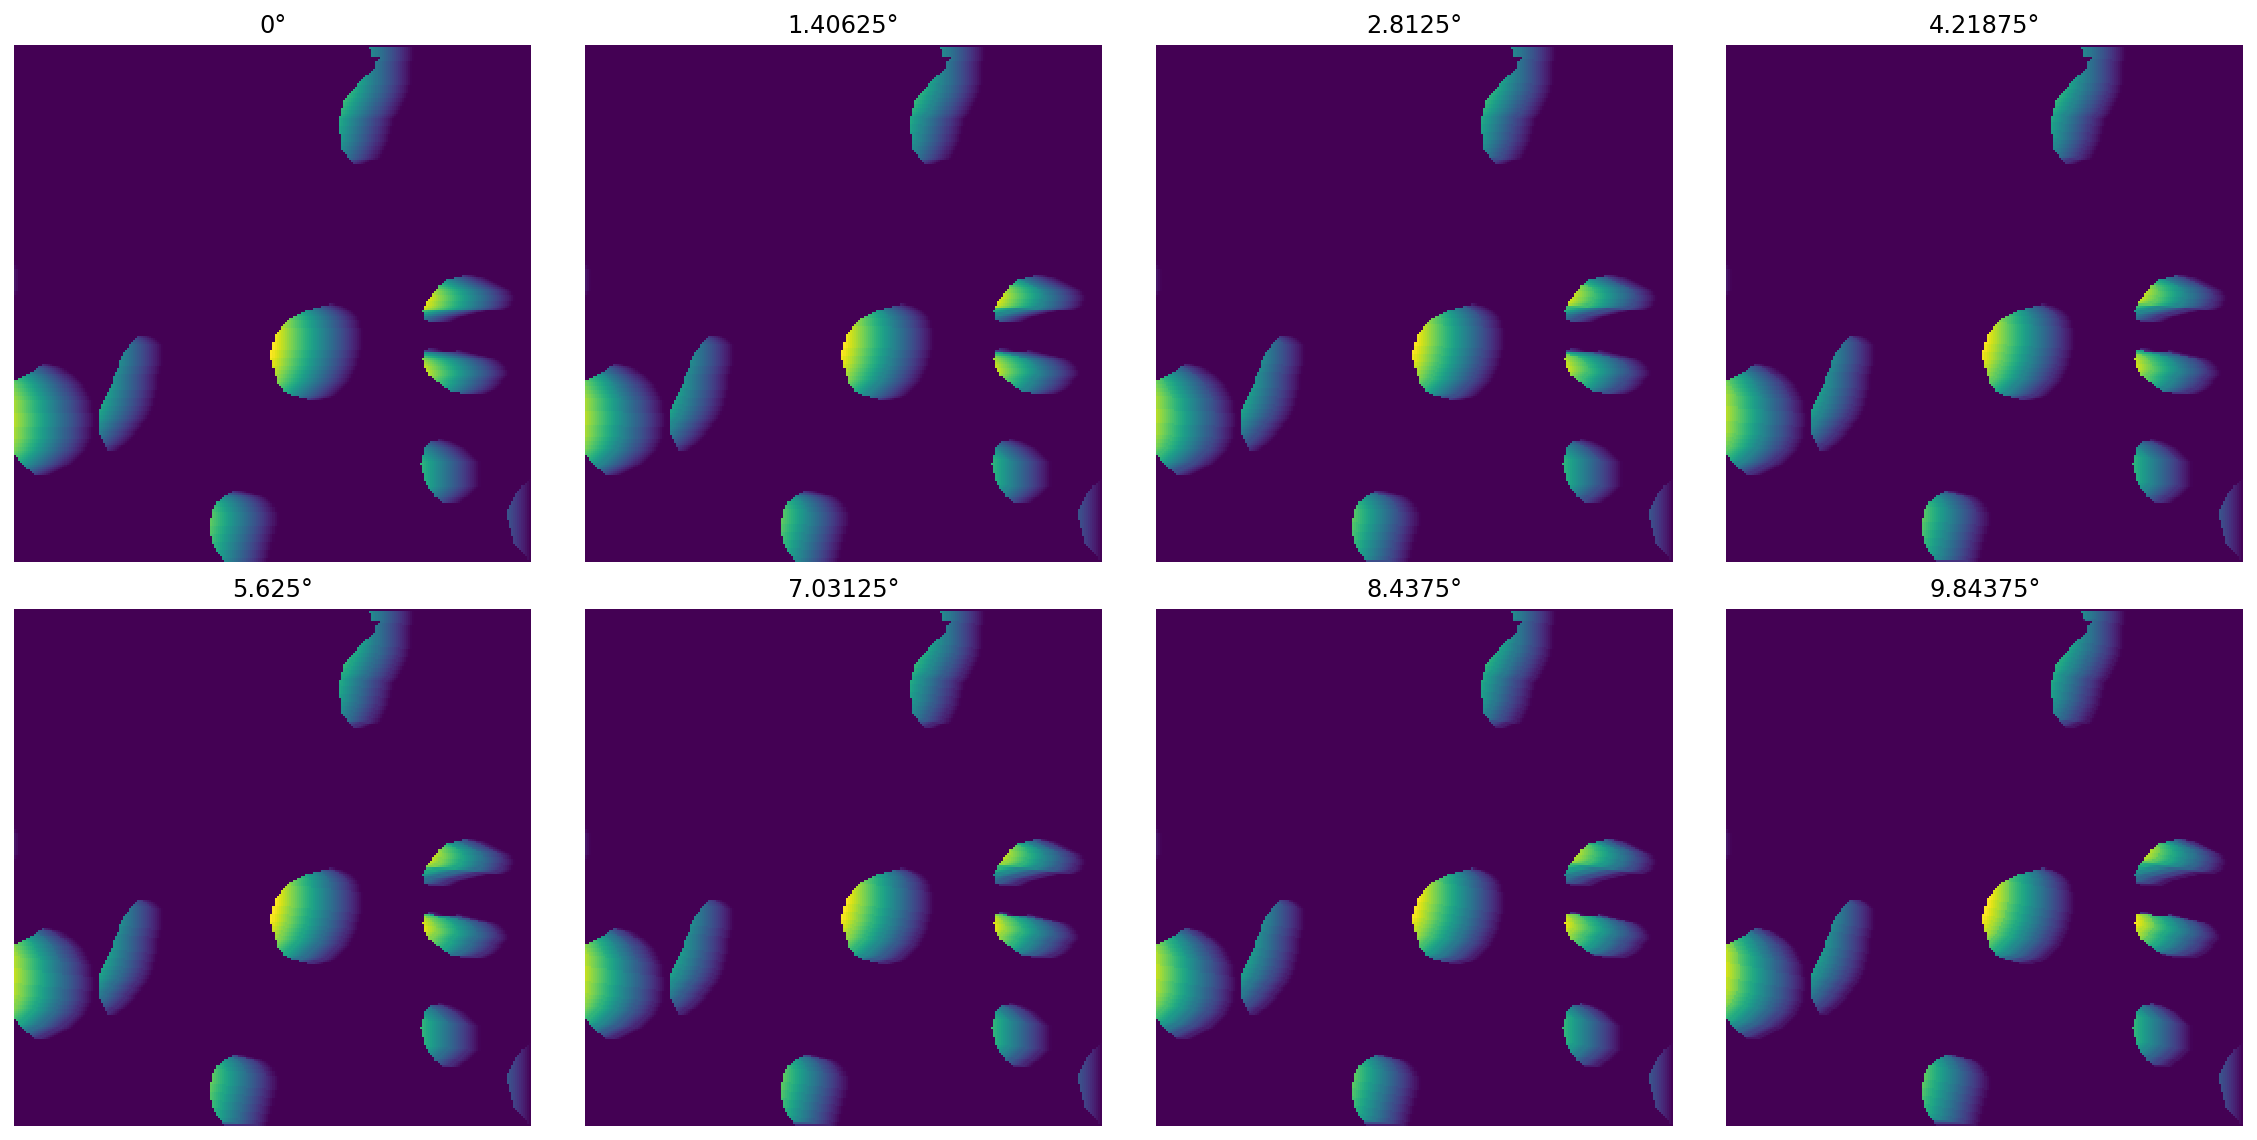

In [14]:
n_rays = 256
angl = ray_angles(n_rays)
dist = star_dist(lbl,n_rays)
fig, ax = plt.subplots(2,4, figsize=(16,8))
for a,d,g in zip(ax.flat,np.moveaxis(dist,-1,0),angl):
    a.imshow(d,cmap='viridis')
    a.set_title('%g°'%np.rad2deg(g))
    a.axis('off')
plt.tight_layout()
None;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


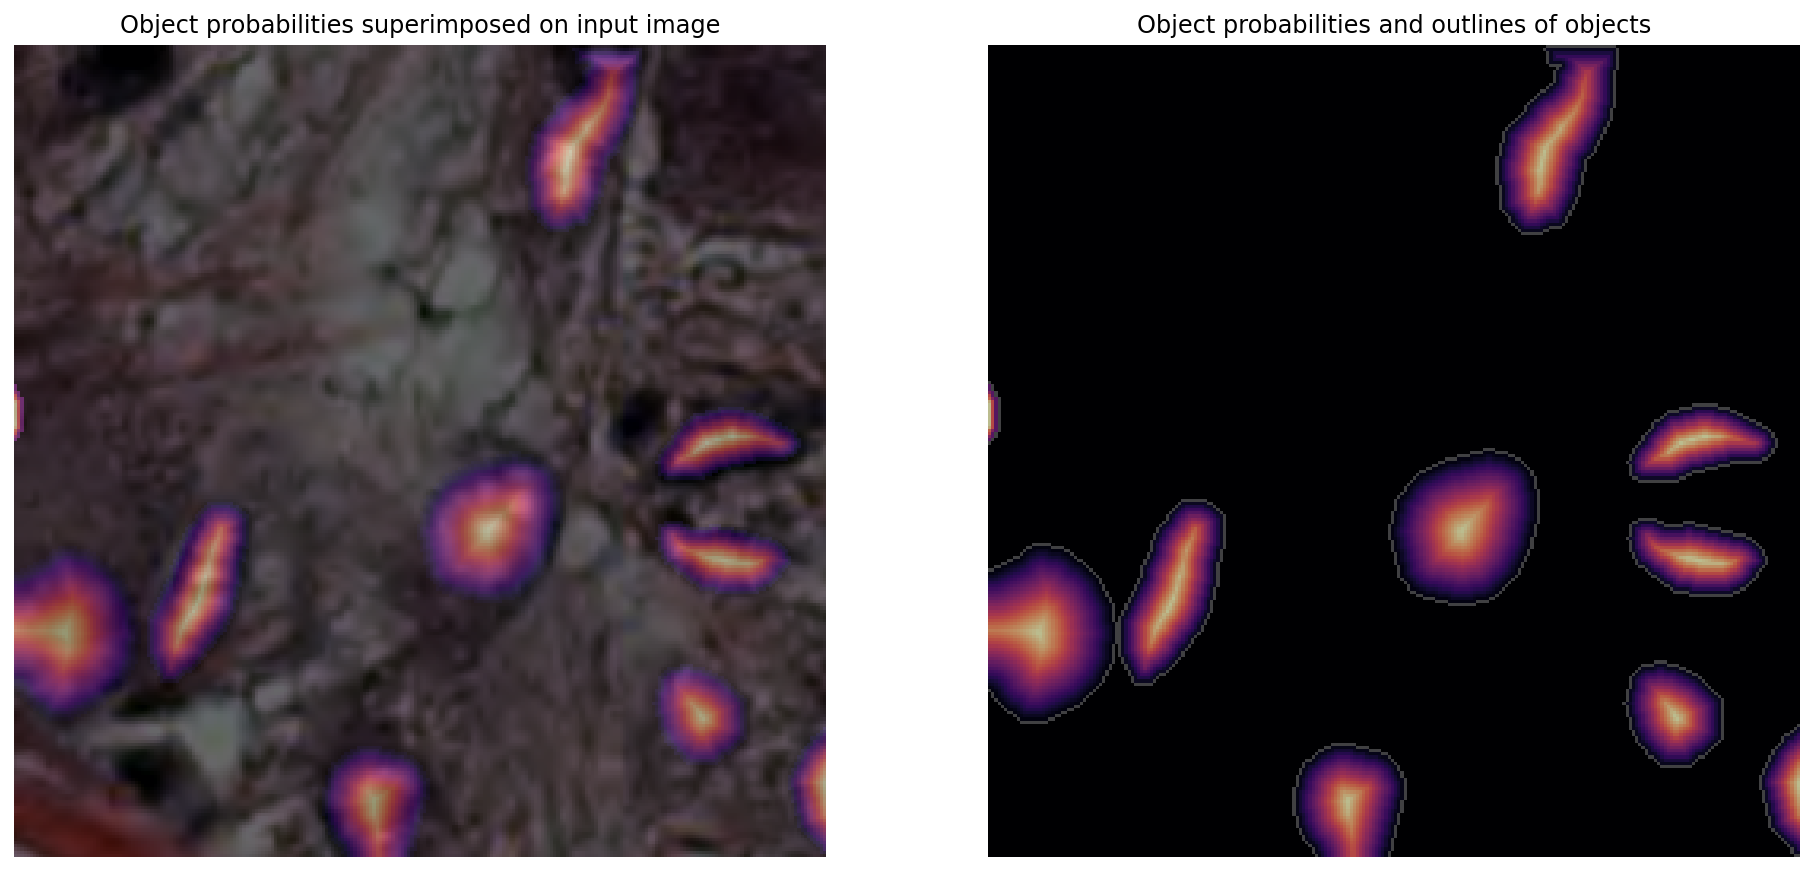

In [15]:
prob = edt_prob(lbl)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.6)
plt.title('Object probabilities superimposed on input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(find_boundaries(lbl!=0,mode='outer'),cmap='gray')
plt.imshow(prob,cmap='magma',alpha=0.75)
plt.title('Object probabilities and outlines of objects')
plt.axis('off')
None;

In [27]:
n_rays = 128
prob = edt_prob(lbl)
dist = star_dist(lbl, n_rays)

In [28]:
coord = dist_to_coord(dist)

In [29]:
points = non_maximum_suppression(coord, prob, prob_thresh=0.5)

In [30]:
labels = polygons_to_label(coord, prob, points)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


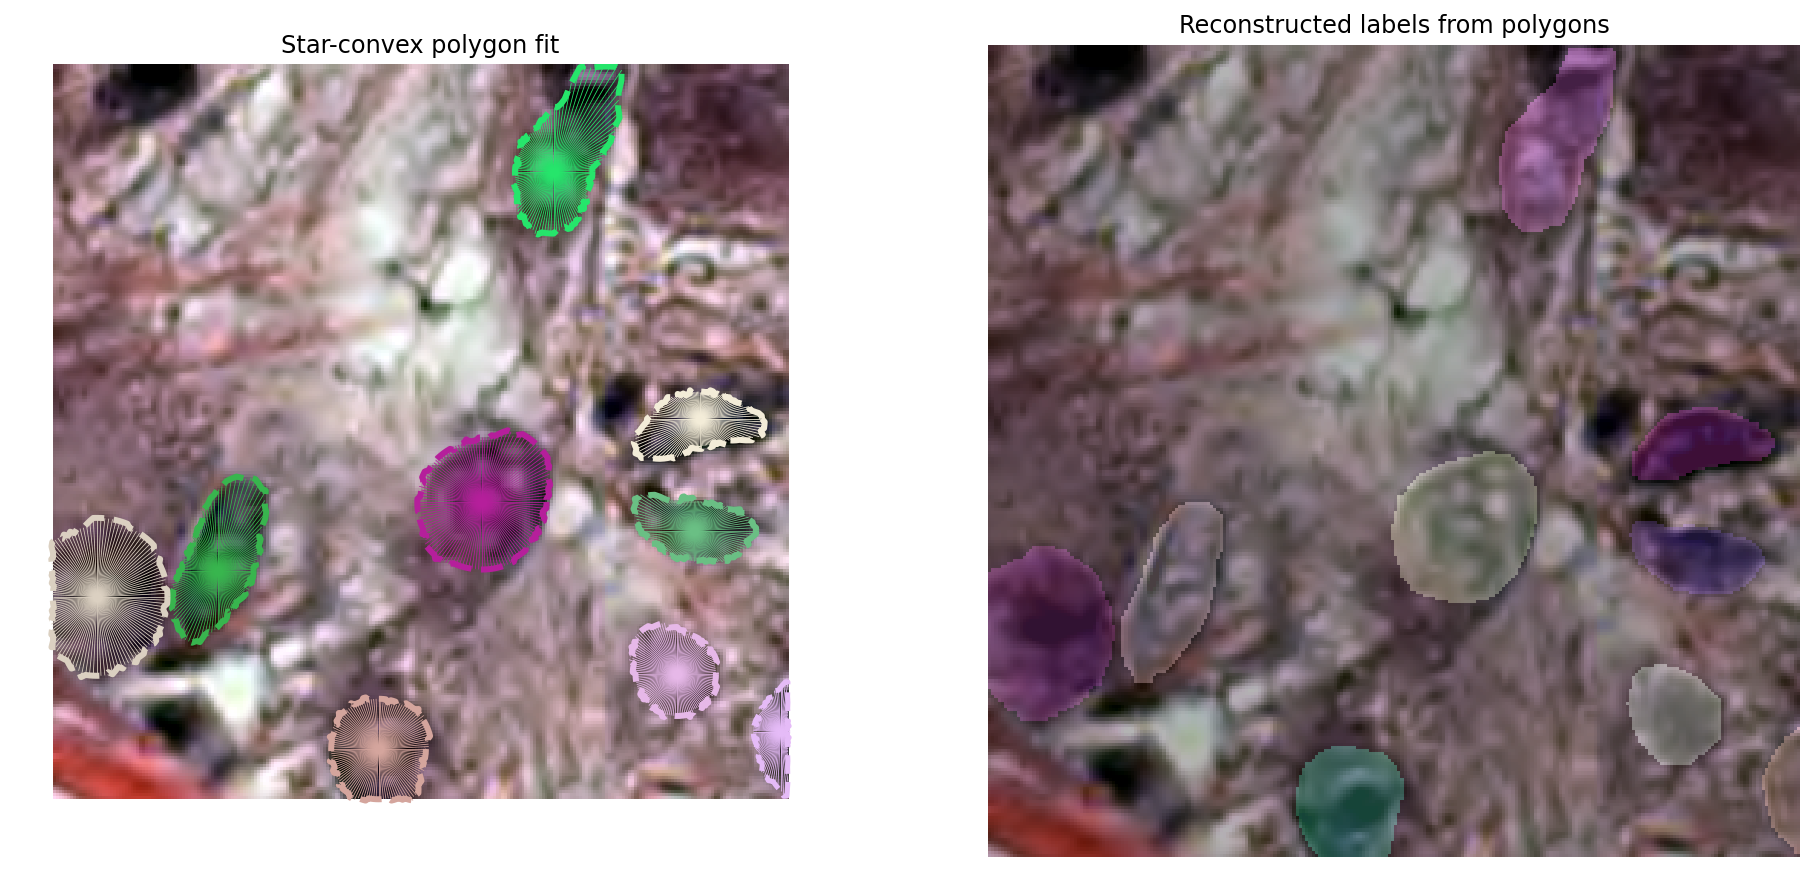

In [31]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
draw_polygons(coord,prob,points,show_dist=True)
plt.axis('off')
plt.title('Star-convex polygon fit')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.imshow(labels,cmap=lbl_cmap,alpha=0.3)
plt.axis('off')
plt.title('Reconstructed labels from polygons')
None;

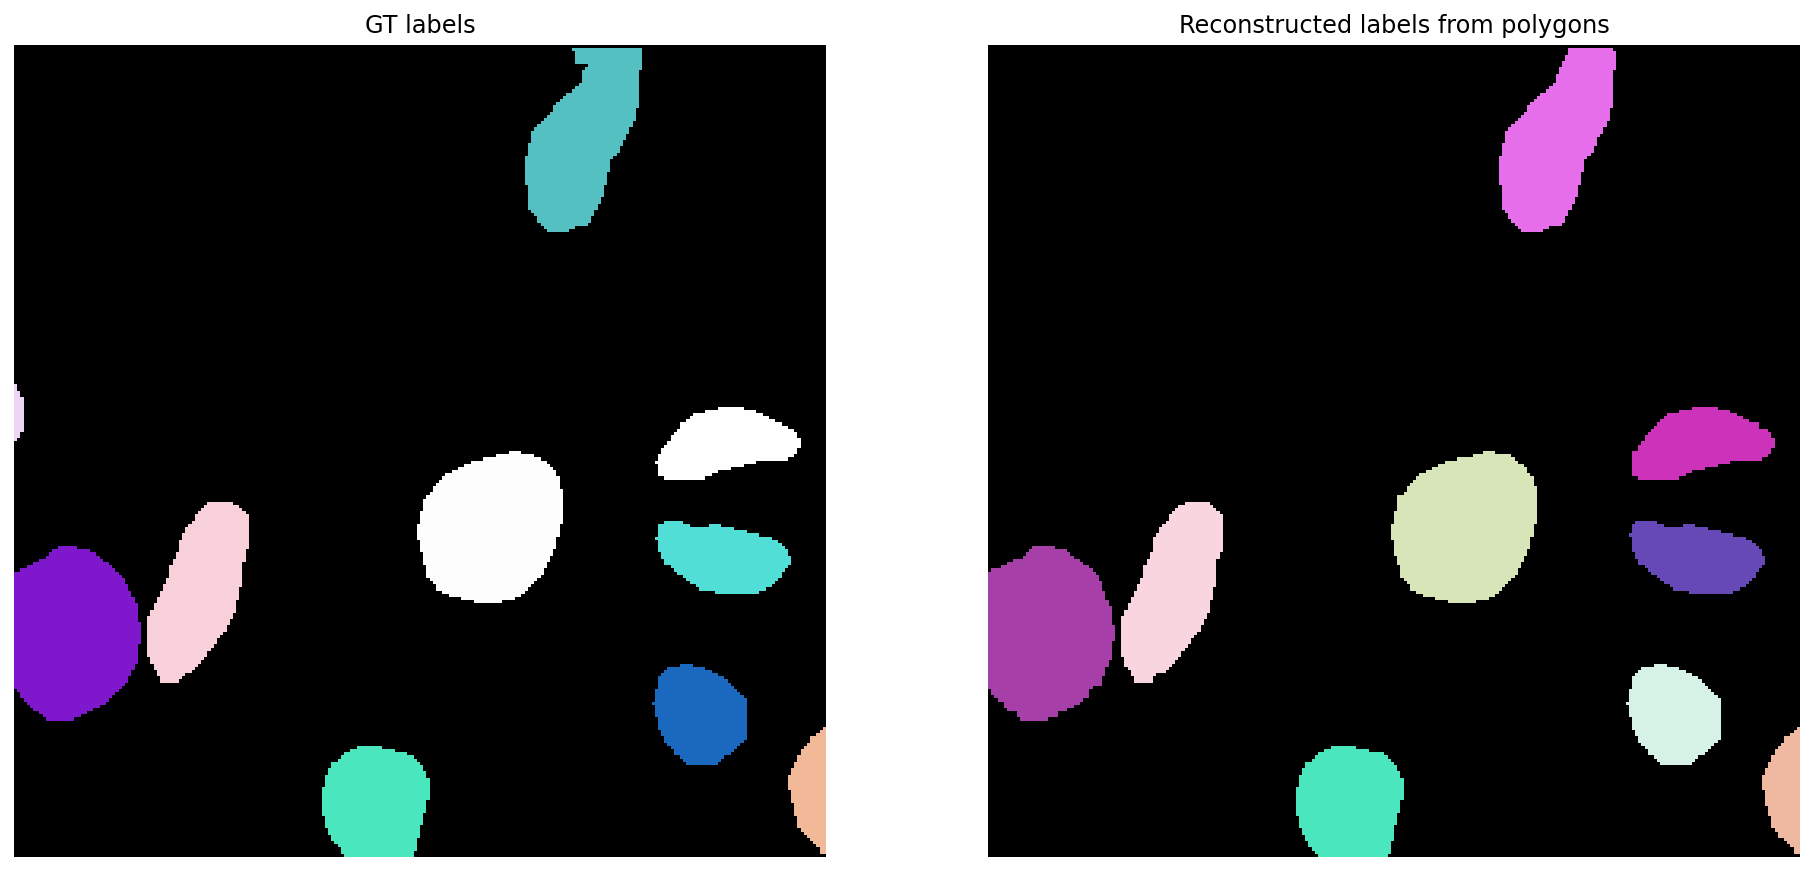

In [32]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(lbl,   cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.subplot(122); plt.imshow(labels,cmap=lbl_cmap); plt.axis('off'); plt.title('Reconstructed labels from polygons')
None;